# Example: Deep learning
------------------------

This example shows how to use ATOM to train and validate a Convolutional Neural Network implemented with [Keras](https://keras.io/) using [scikeras](https://www.adriangb.com/scikeras/refs/heads/master/index.html).

Import the MNIST dataset from [keras.datasets](https://keras.io/api/datasets/mnist/). This is a well known image dataset whose goal is to classify handwritten digits.

## Load the data

In [1]:
# Disable annoying tf warnings
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

from tensorflow import get_logger
get_logger().setLevel('ERROR')

import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

from atom import ATOMClassifier, ATOMModel
from sklearn.preprocessing import FunctionTransformer
from optuna.pruners import PatientPruner
from optuna.distributions import CategoricalDistribution, IntDistribution

from scikeras.wrappers import KerasClassifier
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, Dropout

In [2]:
# Create the convolutional neural network
class ConvNN(KerasClassifier):
    """Convolutional neural network model."""

    @property
    def feature_encoder(self):
        """Convert the 2d input to the image's format (len(X), 28, 28, 1)."""
        return FunctionTransformer(
            func=lambda X: X.reshape(X.shape[0], 28, 28, 1),
        )

    @staticmethod
    def _keras_build_fn():
        """Create the model's architecture."""
        model = Sequential()
        model.add(
            Conv2D(
                filters=8,
                kernel_size=3,
                activation="relu",
                input_shape=(28, 28, 1),
            )
        )
        # model.add(Conv2D(filters=4, kernel_size=5, activation="relu"))
        model.add(Flatten())
        model.add(Dense(units=10, activation="softmax"))
        model.compile(
            optimizer="adam",
            loss="sparse_categorical_crossentropy",
        )

        return model

In [3]:
# Convert the model to an ATOM model
model = ATOMModel(
    estimator=ConvNN(verbose=0),
    acronym="CNN",
    needs_scaling=True,  # Applies automated feature scaling before fitting
    has_validation="epochs",  # Applies in-training validation on parameter epochs
)

In [4]:
# Download the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Flatten data to follow sklearn's API (2d input)
X_train = X_train.reshape(len(X_train), -1)
X_test = X_test.reshape(len(X_test), -1)

data = (X_train, y_train), (X_test, y_test)

## Run the pipeline

In [5]:
atom = ATOMClassifier(*data, n_rows=0.1, n_jobs=1, verbose=2, random_state=1)

<< ================== ATOM ================== >>
Algorithm task: multiclass classification.

Dataset stats ==================== >>
Shape: (7000, 785)
Memory: 5.50 MB
Scaled: False
Outlier values: 41839 (0.9%)
-------------------------------------
Train set size: 6000
Test set size: 1000
-------------------------------------
|   |     dataset |       train |        test |
| - | ----------- | ----------- | ----------- |
| 0 |   708 (1.2) |   619 (1.2) |    89 (1.1) |
| 1 |   765 (1.3) |   648 (1.3) |   117 (1.4) |
| 2 |   648 (1.1) |   548 (1.1) |   100 (1.2) |
| 3 |   744 (1.3) |   647 (1.3) |    97 (1.2) |
| 4 |   721 (1.2) |   607 (1.2) |   114 (1.4) |
| 5 |   592 (1.0) |   508 (1.0) |    84 (1.0) |
| 6 |   702 (1.2) |   596 (1.2) |   106 (1.3) |
| 7 |   725 (1.2) |   634 (1.2) |    91 (1.1) |
| 8 |   674 (1.1) |   572 (1.1) |   102 (1.2) |
| 9 |   721 (1.2) |   621 (1.2) |   100 (1.2) |



In [6]:
# Like any other model, we can define custom distributions for hyperparameter tuning
atom.run(
    models=model,
    metric="f1_weighted",
    n_trials=12,
    ht_params={
        "distributions": {
            "epochs": IntDistribution(10, 20),
            "batch_size": CategoricalDistribution([128, 256, 512]),
        },
    }
)


Training ========================= >>
Models: CNN
Metric: f1_weighted


Running hyperparameter tuning for ConvNN...
| trial |  epochs | batch_size | f1_weighted | best_f1_weighted | time_trial | time_ht |    state |
| ----- | ------- | ---------- | ----------- | ---------------- | ---------- | ------- | -------- |
| 0     |      14 |        128 |      0.9289 |           0.9289 |     8.653s |  8.653s | COMPLETE |
| 1     |      11 |        512 |      0.9813 |           0.9813 |     5.419s | 14.072s | COMPLETE |
| 2     |      14 |        512 |      0.9895 |           0.9895 |     6.476s | 20.548s | COMPLETE |
| 3     |      12 |        128 |      0.9872 |           0.9895 |     7.201s | 27.748s | COMPLETE |
| 4     |      14 |        128 |      0.9289 |           0.9895 |     0.501s | 28.250s | COMPLETE |
| 5     |      18 |        128 |      0.9918 |           0.9918 |     9.587s | 37.836s | COMPLETE |
| 6     |    0/19 |        128 |      0.9896 |           0.9918 |     1.812s | 39.6

## Analyze the results

In [7]:
atom.cnn.trials

params  \
trial                                          
0          {'epochs': 14, 'batch_size': 128}   
1          {'epochs': 11, 'batch_size': 512}   
2          {'epochs': 14, 'batch_size': 512}   
3          {'epochs': 12, 'batch_size': 128}   
4          {'epochs': 14, 'batch_size': 128}   
5          {'epochs': 18, 'batch_size': 128}   
6      {'epochs': '0/19', 'batch_size': 128}   
7      {'epochs': '0/11', 'batch_size': 128}   
8      {'epochs': '0/20', 'batch_size': 256}   
9      {'epochs': '0/17', 'batch_size': 128}   
10         {'epochs': 18, 'batch_size': 256}   
11         {'epochs': 18, 'batch_size': 256}   

                                               estimator     score time_trial  \
trial                                                                           
0      ConvNN(\n\tmodel=None\n\tbuild_fn=None\n\twarm...  0.928914   8.652858   
1      ConvNN(\n\tmodel=None\n\tbuild_fn=None\n\twarm...  0.981337   5.418926   
2      ConvNN(\n\tmodel=None\n\tbuild_fn=None\n\twarm...  0.989524   6.475881   
3      ConvNN(\n\tmodel=None\n\tbuild_fn=None\n\twarm...  0.987199    7.20054   
4      ConvNN(\n\tmodel=None\n\tbuild_fn=None\n\twarm...  0.928914   0.501456   
5      ConvNN(\n\tmodel=None\n\tbuild_fn=None\n\twarm...  0.991835   9.586706   
6      ConvNN(\n\tmodel=None\n\tbuild_fn=None\n\twarm...  0.989623   1.812356   
7      ConvNN(\n\tmodel=None\n\tbuild_fn=None\n\twarm...  0.987222   1.784515   
8      ConvNN(\n\tmodel=None\n\tbuild_fn=None\n\twarm...  0.989524   1.714184   
9      ConvNN(\n\tmodel=None\n\tbuild_fn=None\n\twarm...  0.994172   2.010827   
10     ConvNN(\n\tmodel=None\n\tbuild_fn=None\n\twarm...       1.0   8.193789   
11     ConvNN(\n\tmodel=None\n\tbuild_fn=None\n\twarm...       1.0    0.47243   

         time_ht     state  
trial                       
0       8.652858  COMPLETE  
1      14.071784  COMPLETE  
2      20.547665  COMPLETE  
3      27.748205  COMPLETE  
4      28.249661  COMPLETE  
5      37.836367  COMPLETE  
6      39.648723    PRUNED  
7      41.433238    PRUNED  
8      43.147422    PRUNED  
9      45.158249    PRUNED  
10     53.352038  COMPLETE  
11     53.824468  COMPLETE

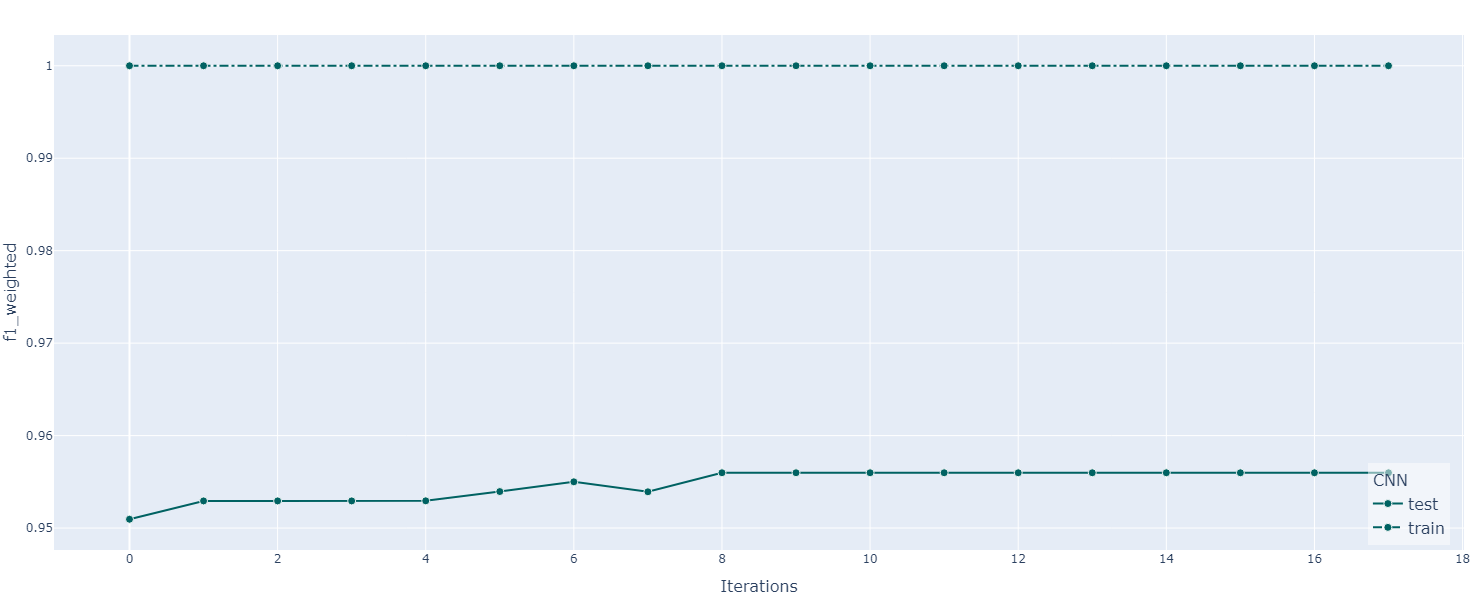

In [8]:
atom.plot_evals(dataset="test+train")

In [9]:
# Use the prediction methods like any other model
atom.cnn.predict_proba(X_train)

0             1             2             3             4  \
0      2.667587e-11  1.423204e-15  1.897321e-09  4.177241e-03  1.959917e-24   
1      1.000000e+00  1.088900e-21  5.665938e-11  1.283312e-12  5.244474e-19   
2      1.604274e-14  6.149738e-11  9.691398e-09  7.262639e-06  9.290258e-01   
3      4.614237e-10  9.999845e-01  1.029637e-05  3.167258e-07  9.058624e-09   
4      5.340953e-18  4.043613e-15  5.067610e-23  3.933897e-12  1.525269e-06   
...             ...           ...           ...           ...           ...   
59995  4.641701e-13  5.263499e-17  3.007880e-13  2.409940e-09  1.768155e-19   
59996  1.147092e-09  2.389565e-19  1.974684e-05  9.999623e-01  1.673667e-19   
59997  2.882433e-17  1.390950e-14  8.691903e-22  3.209542e-11  2.343726e-15   
59998  5.087094e-12  2.245045e-18  4.680251e-12  2.838577e-14  2.635410e-10   
59999  2.945166e-05  1.761085e-11  1.337117e-10  2.293348e-10  6.817801e-12   

                  5             6             7             8             9  
0      9.958220e-01  5.378779e-17  6.769880e-07  3.797666e-15  7.466505e-08  
1      8.513763e-14  1.282690e-13  6.353681e-13  8.923981e-14  6.010767e-15  
2      3.314378e-15  2.463762e-21  7.028911e-02  1.143039e-16  6.777486e-04  
3      6.250572e-09  4.113872e-13  2.947045e-07  4.647981e-06  3.105437e-10  
4      5.161619e-12  2.803127e-18  3.035959e-07  7.792316e-09  9.999982e-01  
...             ...           ...           ...           ...           ...  
59995  3.314675e-09  6.546399e-20  2.068865e-17  1.000000e+00  1.930476e-11  
59996  1.556348e-06  3.198247e-21  1.960399e-18  1.608568e-05  2.387261e-07  
59997  1.000000e+00  7.243893e-17  8.511273e-23  4.616474e-10  5.207763e-11  
59998  5.397062e-10  1.000000e+00  6.982087e-15  8.221984e-15  6.926972e-19  
59999  1.130618e-02  1.809152e-11  3.875938e-13  9.886596e-01  4.672157e-06  

[60000 rows x 10 columns]

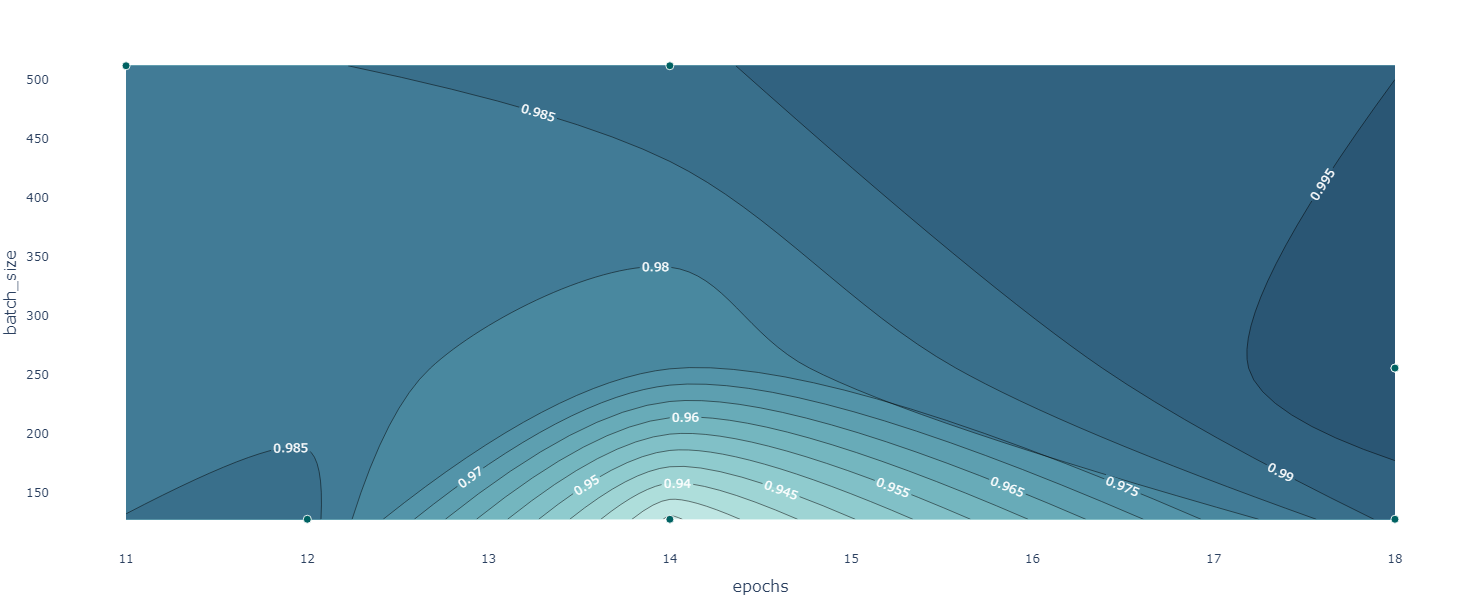

In [10]:
# Or make plots...
atom.cnn.plot_hyperparameters()